# Getting Fall Types Data

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML
import os
import glob
import io
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

In [6]:
subject_folders = os.listdir("new data")
column_names = ["accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"]
combined_data = pd.DataFrame(columns=column_names)

activity = {'fall': 'Fall', 'jogging': 'Jogging', 'sitting': 'Sitting action', 'walking': 'Walking', 'stairsdown': \
            'climbing stairs', 'stairsup': 'climbing stairs', 'gettingup': 'getting up'}

for i in subject_folders:
    temp_folder = []
    if(i != 'combined_data.csv'):
        temp_folder = os.listdir("new data/" + i)
        number_files = len(temp_folder)
        print("Reading folder: " + i)
        for j in temp_folder:
            print("\tReading internal folder: " + j)
            files = os.listdir("new data/" + i + "/" + j)
            for k in files:
#                 print(k)
                if j == "fall":
                    fall_files = os.listdir("new data/" + i + "/" + j + "/" + k)
                    for l in fall_files:
                        file = io.BytesIO(open("new data/" + i + "/" + j + "/" + k + "/" + l, 'rb').read().replace(b';',b''))
                        data = np.genfromtxt(file,dtype=float,delimiter=',')
                        df = pd.DataFrame(data, columns = column_names)
                        df = df.iloc[1: , :]
                        df["user"] = i
                        df["fall_type"] = k
                        combined_data = combined_data.append(df)
combined_data

Reading folder: Ramana
	Reading internal folder: fall
	Reading internal folder: idle
Reading folder: Wamika
	Reading internal folder: fall
	Reading internal folder: gettingup
	Reading internal folder: idle
	Reading internal folder: sitting
	Reading internal folder: walking
Reading folder: Wira
	Reading internal folder: fall
	Reading internal folder: gettingup
	Reading internal folder: idle
	Reading internal folder: sitting
	Reading internal folder: walking
Reading folder: Zeon
	Reading internal folder: fall
	Reading internal folder: gettingup
	Reading internal folder: idle
	Reading internal folder: sitting
	Reading internal folder: walking


,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,fall_type
1,0.05,0.01,1.00,-5.91,-0.68,-2.78,Ramana,left
2,0.05,0.01,1.00,-1.95,-0.20,-1.31,Ramana,left
3,0.06,0.00,1.01,-1.33,0.11,-1.13,Ramana,left
4,0.06,0.01,1.00,-0.24,0.96,-0.82,Ramana,left
5,0.05,0.01,1.00,-0.11,1.33,-0.70,Ramana,left
...,...,...,...,...,...,...,...,...
56,0.97,-0.87,0.99,2.75,-7.24,-0.03,Zeon,right
57,1.01,-0.90,0.95,3.67,-4.25,3.75,Zeon,right
58,1.01,-0.89,0.89,8.67,6.68,3.33,Zeon,right
59,1.00,-0.83,0.92,5.56,3.63,-1.07,Zeon,right


In [7]:
combined_data.to_csv("new data/combined_data_fall_types.csv", index=False)

# Training Data

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import math

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, LSTM, Embedding, SimpleRNN, GRU
from keras.utils import np_utils
from tensorflow.keras import optimizers

import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv("new data/combined_data_fall_types.csv")

data

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,fall_type
0,0.05,0.01,1.00,-5.91,-0.68,-2.78,Ramana,left
1,0.05,0.01,1.00,-1.95,-0.20,-1.31,Ramana,left
2,0.06,0.00,1.01,-1.33,0.11,-1.13,Ramana,left
3,0.06,0.01,1.00,-0.24,0.96,-0.82,Ramana,left
4,0.05,0.01,1.00,-0.11,1.33,-0.70,Ramana,left
...,...,...,...,...,...,...,...,...
8695,0.97,-0.87,0.99,2.75,-7.24,-0.03,Zeon,right
8696,1.01,-0.90,0.95,3.67,-4.25,3.75,Zeon,right
8697,1.01,-0.89,0.89,8.67,6.68,3.33,Zeon,right
8698,1.00,-0.83,0.92,5.56,3.63,-1.07,Zeon,right


In [6]:
# data_online = pd.read_csv("Sisfall_dataset/processed_data.csv")
# data_online

In [7]:
# data_online = data_online[data_online['broad_mapped_activity'] == 'Fall']
# data_online = data_online.drop('activity', axis = 1)
# data_online.rename({'mapped_activity':'fall_type'}, axis = 1)
# data = data.append(data_online)
# data

In [8]:
data.replace(to_replace='left', value = 'lateral', inplace = True)
data.replace(to_replace='right', value = 'lateral', inplace = True)

In [9]:
# All data collected in 20Hz sample rate.

# Set display upto 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Labels are all the activity groups
# LABELS = list(data.groupby(["broad_mapped_activity"]).groups.keys())
LABELS = list(data.groupby(["fall_type"]).groups.keys())

no_of_features = 6

# The number of steps within one time segment (window size)
TIME_PERIODS = 60
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 15

LABELS

['backward', 'forward', 'lateral']

In [10]:
# split the data into training and test set
Training_data = data[data["user"].isin(['Ramana', 'Wira', 'Zeon'])]
print(Training_data.shape)
Test_data = data[data["user"].isin(['Wamika'])]
Test_data

(6300, 8)


,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,fall_type
1380,0.050,0.050,0.770,-6.490,5.980,-1.410,Wamika,backward
1381,0.050,0.050,0.780,-6.310,5.490,-1.170,Wamika,backward
1382,0.050,0.050,0.780,-6.130,4.520,-1.410,Wamika,backward
1383,0.050,0.050,0.780,-5.520,4.330,-1.350,Wamika,backward
1384,0.050,0.060,0.790,-6.620,3.840,-1.660,Wamika,backward
...,...,...,...,...,...,...,...,...
3775,1.860,-0.110,1.610,1.640,29.880,-22.430,Wamika,lateral
3776,1.820,-0.060,1.680,1.830,32.200,-24.560,Wamika,lateral
3777,1.830,-0.040,1.630,6.220,30.250,-17.540,Wamika,lateral
3778,1.790,-0.020,1.700,11.650,35.430,-12.050,Wamika,lateral


In [11]:
# Encode labels
le = preprocessing.LabelEncoder()
Training_data['encoded_label'] = le.fit_transform(Training_data['fall_type'].values.ravel())
print(list(le.classes_))

['backward', 'forward', 'lateral']


In [12]:
def normalize_features(data, mu, sigma):
    print("mean: ", mu)
    print("standard deviation: ", sigma)
    return (data - mu)/sigma
#     maxim = np.max(data, axis=0)
#     minim = np.min(data, axis=0)
#     return (data - minim)/(maxim - minim)

In [13]:
mu = []
sigma = []
for i in range(0,6):
    print(Training_data.columns[i])
    mu.append(np.mean(Training_data.iloc[:, i], axis=0))
    sigma.append(np.std(Training_data.iloc[:, i], axis=0))
    Training_data.iloc[:, i] = normalize_features(Training_data.iloc[:, i], mu[i], sigma[i])
    
Training_data

accel_x
mean:  0.08631587301587361
standard deviation:  0.8064239886254493
accel_y
mean:  -0.3774698412698392
standard deviation:  1.6709515428684094
accel_z
mean:  0.5091603174603166
standard deviation:  1.6642222578444024
gyro_x
mean:  7.289014285714277
standard deviation:  182.7268925086552
gyro_y
mean:  3.087561904761896
standard deviation:  118.43303420381595
gyro_z
mean:  2.268784126984129
standard deviation:  113.53857885995292


,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,fall_type,encoded_label
0,-0.045,0.232,0.295,-0.072,-0.032,-0.044,Ramana,lateral,2
1,-0.045,0.232,0.295,-0.051,-0.028,-0.032,Ramana,lateral,2
2,-0.033,0.226,0.301,-0.047,-0.025,-0.030,Ramana,lateral,2
3,-0.033,0.232,0.295,-0.041,-0.018,-0.027,Ramana,lateral,2
4,-0.045,0.232,0.295,-0.040,-0.015,-0.026,Ramana,lateral,2
...,...,...,...,...,...,...,...,...,...
8695,1.096,-0.295,0.289,-0.025,-0.087,-0.020,Zeon,lateral,2
8696,1.145,-0.313,0.265,-0.020,-0.062,0.013,Zeon,lateral,2
8697,1.145,-0.307,0.229,0.008,0.030,0.009,Zeon,lateral,2
8698,1.133,-0.271,0.247,-0.009,0.005,-0.029,Zeon,lateral,2


In [14]:
def create_segments(data):

    segments = []
    labels = []
    for i in range(0, len(data) - TIME_PERIODS, STEP_DISTANCE):
        accel_xs = data['accel_x'].values[i: i + TIME_PERIODS]
        accel_ys = data['accel_y'].values[i: i + TIME_PERIODS]
        accel_zs = data['accel_z'].values[i: i + TIME_PERIODS]
        gyro_xs = data['gyro_x'].values[i: i + TIME_PERIODS]
        gyro_ys = data['gyro_y'].values[i: i + TIME_PERIODS]
        gyro_zs = data['gyro_z'].values[i: i + TIME_PERIODS]
#         mag_xs = data['mag_x'].values[i: i + TIME_PERIODS]
#         mag_ys = data['mag_y'].values[i: i + TIME_PERIODS]
#         mag_zs = data['mag_z'].values[i: i + TIME_PERIODS]
        
#         #Features
#         #mean
#         accel_x_mean = np.full(TIME_PERIODS, accel_xs.mean())
#     #     y_mean = np.full(TIME_PERIODS, ys.mean())
#         accel_z_mean = np.full(TIME_PERIODS, accel_zs.mean())
#         gyro_x_mean = np.full(TIME_PERIODS, gyro_xs.mean())
#     #     pitch_mean = np.full(TIME_PERIODS, pitchs.mean())
#         gyro_z_mean = np.full(TIME_PERIODS, gyro_zs.mean())
#         #standard deviation
#         accel_x_std = np.full(TIME_PERIODS, accel_xs.std())
#         accel_y_std = np.full(TIME_PERIODS, accel_ys.std())
#         accel_z_std = np.full(TIME_PERIODS, accel_zs.std())
#         gyro_x_std = np.full(TIME_PERIODS, gyro_xs.std())
#         gyro_y_std = np.full(TIME_PERIODS, gyro_ys.std())
#         gyro_z_std = np.full(TIME_PERIODS, gyro_zs.std())
#         #min
#         accel_x_min = np.full(TIME_PERIODS, accel_xs.min())
#         accel_y_min = np.full(TIME_PERIODS, accel_ys.min())
#         accel_z_min = np.full(TIME_PERIODS, accel_zs.min())
#         gyro_x_min = np.full(TIME_PERIODS, gyro_xs.min())
#     #     pitch_min = np.full(TIME_PERIODS, pitchs.min())
#     #     yaw_min = np.full(TIME_PERIODS, yaws.min())
    
#         #energy, here ** represents exponentiation
#         accel_x_eng = np.full(TIME_PERIODS, np.sum(accel_xs**2)/TIME_PERIODS) 
#         accel_y_eng = np.full(TIME_PERIODS, np.sum(accel_ys**2)/TIME_PERIODS)
#         accel_z_eng = np.full(TIME_PERIODS, np.sum(accel_zs**2)/TIME_PERIODS)
#         #median absolute deviation (MAD)
#         accel_x_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(accel_xs))
#     #     y_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(ys))
#         accel_z_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(accel_zs))
#     #     roll_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(rolls))
#         gyro_y_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(gyro_ys))
#         gyro_z_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(gyro_zs))
#         # signal magnitude area
#         accel_sma = np.full(TIME_PERIODS, (np.sum(np.abs(accel_xs)) + np.sum(np.abs(accel_ys)) + np.sum(np.abs(accel_zs))) / TIME_PERIODS)
#         gyro_sma = np.full(TIME_PERIODS, (np.sum(np.abs(gyro_xs)) + np.sum(np.abs(gyro_ys)) + np.sum(np.abs(gyro_zs))) / TIME_PERIODS)
# #         # get frequency domain signal
# #         x_freq = np.abs(np.fft.fft(xs))[1:51]
# #         y_freq = np.abs(np.fft.fft(ys))[1:51]
# #         z_freq = np.abs(np.fft.fft(zs))[1:51]
# #         roll_freq = np.abs(np.fft.fft(rolls))[1:51]
# #         pitch_freq = np.abs(np.fft.fft(pitchs))[1:51]
# #         yaw_freq = np.abs(np.fft.fft(yaws))[1:51]
# #         # freq mean
# #         x_freq_mean = np.full(TIME_PERIODS, x_freq.mean())
# #         y_freq_mean = np.full(TIME_PERIODS, y_freq.mean())
# #         z_freq_mean = np.full(TIME_PERIODS, z_freq.mean())
# #         roll_freq_mean = np.full(TIME_PERIODS, roll_freq.mean())
# #         pitch_freq_mean = np.full(TIME_PERIODS, pitch_freq.mean())
# #         yaw_freq_mean = np.full(TIME_PERIODS, yaw_freq.mean())
# #         #freq standard deviation
# #         x_freq_std = np.full(TIME_PERIODS, x_freq.std())
# #         y_freq_std = np.full(TIME_PERIODS, y_freq.std())
# #         z_freq_std = np.full(TIME_PERIODS, z_freq.std())
# #         roll_freq_std = np.full(TIME_PERIODS, roll_freq.std())
# #         pitch_freq_std = np.full(TIME_PERIODS, pitch_freq.std())
# #         yaw_freq_std = np.full(TIME_PERIODS, yaw_freq.std())

        # Retrieve the most often used label in this segment
        label = stats.mode(data['encoded_label'][i: i + TIME_PERIODS])[0][0]
        
#         segments.append([accel_xs, accel_ys, accel_zs, gyro_xs, gyro_ys, gyro_zs, accel_x_mean,\
#                          accel_z_mean, gyro_x_mean, gyro_z_mean, accel_x_std, accel_y_std, accel_z_std, gyro_x_std,  gyro_y_std, \
#                          gyro_z_std, accel_x_min, accel_y_min, accel_z_min, gyro_x_min, accel_x_eng, accel_y_eng, accel_z_eng, \
#                          accel_x_mad, accel_z_mad, gyro_y_mad, gyro_z_mad, accel_sma, gyro_sma])
        segments.append([accel_xs, accel_ys, accel_zs, gyro_xs, gyro_ys, gyro_zs])
        labels.append(label)

    # Bring the segments into a better shape
    x_data = np.asarray(segments, dtype= np.float32).reshape(-1, TIME_PERIODS, no_of_features)
    y_data = np.asarray(labels)
    return x_data, y_data


In [15]:
x_train, y_train = create_segments(Training_data)
np.set_printoptions(threshold=np.inf)
print("x shape: ",x_train.shape)
print("y shape: ",y_train.shape)

x shape:  (416, 60, 6)
y shape:  (416,)


In [16]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS*no_of_features)
x_train.shape

(416, 360)

In [17]:
# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

# One-hot encoding of y_train labels (only execute once!)
y_train = np_utils.to_categorical(y_train, len(LABELS))
print('New y_train shape: ', y_train.shape)

New y_train shape:  (416, 3)


### 1D-CNN Model

In [18]:
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS,no_of_features), input_shape=(TIME_PERIODS*no_of_features,)))
model_m.add(Conv1D(100, 3, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(120, 3, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(80, 3, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.3))
model_m.add(Dense(len(LABELS), activation='softmax'))
print(model_m.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 60, 6)             0         
                                                                 
 conv1d (Conv1D)             (None, 58, 100)           1900      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 100)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 120)           36120     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 120)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 80)             2

In [157]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='loss', patience=2)
]

opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 100

history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/100
3/3 [==============================] - 1s 31ms/step - loss: 1.0762 - accuracy: 0.4760
Epoch 2/100
3/3 [==============================] - 0s 18ms/step - loss: 0.9554 - accuracy: 0.6755
Epoch 3/100
3/3 [==============================] - 0s 18ms/step - loss: 0.8939 - accuracy: 0.7236
Epoch 4/100
3/3 [==============================] - 0s 14ms/step - loss: 0.8138 - accuracy: 0.7548
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - loss: 0.7361 - accuracy: 0.7236
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 0.6796 - accuracy: 0.7668
Epoch 7/100
3/3 [==============================] - 0s 19ms/step - loss: 0.6332 - accuracy: 0.7933
Epoch 8/100
3/3 [==============================] - 0s 17ms/step - loss: 0.5731 - accuracy: 0.7885
Epoch 9/100
3/3 [==============================] - 0s 18ms/step - loss: 0.4987 - accuracy: 0.7885
Epoch 10/100
3/3 [==============================] - 0s 18ms/step - loss: 0.4525 - accuracy: 0.8269
Epoch 11/100
3/3 [=

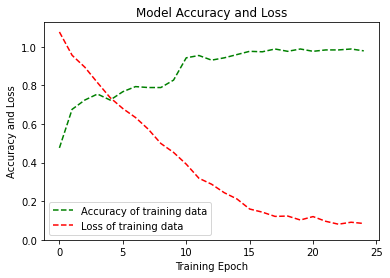

In [158]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [28]:
# Set input_shape / reshape for Keras
# Encode labels
Test_data['encoded_label'] = le.transform(Test_data['fall_type'].values.ravel())
print(list(le.classes_))

for i in range(0,6):
    print(data.columns[i])
    Test_data.iloc[:, i] = normalize_features(Test_data.iloc[:, i], mu[i], sigma[i])
    
x_test, y_test = create_segments(Test_data)
print("x shape: ",x_test.shape)
print("y shape: ",y_test.shape)

x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS*no_of_features)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, len(LABELS))
y_test.shape

['backward', 'forward', 'lateral']
accel_x
mean:  0.08631587301587361
standard deviation:  0.8064239886254493
accel_y
mean:  -0.3774698412698392
standard deviation:  1.6709515428684094
accel_z
mean:  0.5091603174603166
standard deviation:  1.6642222578444024
gyro_x
mean:  7.289014285714277
standard deviation:  182.7268925086552
gyro_y
mean:  3.087561904761896
standard deviation:  118.43303420381595
gyro_z
mean:  2.268784126984129
standard deviation:  113.53857885995292
x shape:  (156, 60, 6)
y shape:  (156,)


(156, 3)

In [160]:
score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

5/5 [==============================] - 0s 14ms/step - loss: 0.1909 - accuracy: 0.9295

Accuracy on test data: 0.93

Loss on test data: 0.19


In [29]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

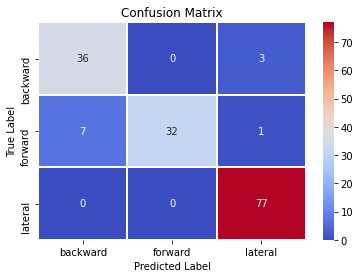


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.84      0.92      0.88        39
           1       1.00      0.80      0.89        40
           2       0.95      1.00      0.97        77

    accuracy                           0.93       156
   macro avg       0.93      0.91      0.91       156
weighted avg       0.93      0.93      0.93       156



In [162]:
y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [163]:
model_m.save('best_model_cnn_fall_types.h5')

In [164]:
print(mu)
print(sigma)

[0.08631587301587361, -0.3774698412698392, 0.5091603174603166, 7.289014285714277, 3.087561904761896, 2.268784126984129]
[0.8064239886254493, 1.6709515428684094, 1.6642222578444024, 182.7268925086552, 118.43303420381595, 113.53857885995292]


### LSTM Model

In [22]:
model_lstm = Sequential()
model_lstm.add(LSTM(200, input_shape=(TIME_PERIODS,no_of_features)))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(100, activation='relu'))
model_lstm.add(Dense(len(LABELS), activation='softmax'))
print(model_lstm.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               165600    
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               20100     
                                                                 
 dense_4 (Dense)             (None, 3)                 303       
                                                                 
Total params: 186,003
Trainable params: 186,003
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS, no_of_features)
x_train.shape

(416, 60, 6)

In [24]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='loss', patience=2)
]

opt = optimizers.Adam(learning_rate=0.001)

model_lstm.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 50

history = model_lstm.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/50
3/3 [==============================] - 2s 36ms/step - loss: 1.0735 - accuracy: 0.5673
Epoch 2/50
3/3 [==============================] - 0s 30ms/step - loss: 0.9996 - accuracy: 0.6034
Epoch 3/50
3/3 [==============================] - 0s 29ms/step - loss: 0.9098 - accuracy: 0.6082
Epoch 4/50
3/3 [==============================] - 0s 27ms/step - loss: 0.8550 - accuracy: 0.6587
Epoch 5/50
3/3 [==============================] - 0s 27ms/step - loss: 0.8207 - accuracy: 0.6683
Epoch 6/50
3/3 [==============================] - 0s 27ms/step - loss: 0.7520 - accuracy: 0.6611
Epoch 7/50
3/3 [==============================] - 0s 29ms/step - loss: 0.7280 - accuracy: 0.6683
Epoch 8/50
3/3 [==============================] - 0s 24ms/step - loss: 0.6268 - accuracy: 0.6851
Epoch 9/50
3/3 [==============================] - 0s 29ms/step - loss: 0.5569 - accuracy: 0.7548
Epoch 10/50
3/3 [==============================] - 0s 23ms/step - loss: 0.4835 - accuracy: 0.7740
Epoch 11/50
3/3 [============

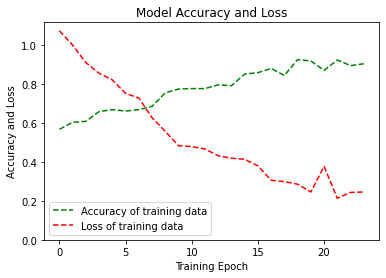

In [25]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [30]:
x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS, no_of_features)
x_test.shape

(156, 60, 6)

In [31]:
score = model_lstm.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

5/5 [==============================] - 1s 34ms/step - loss: 0.3352 - accuracy: 0.8910

Accuracy on test data: 0.89

Loss on test data: 0.34


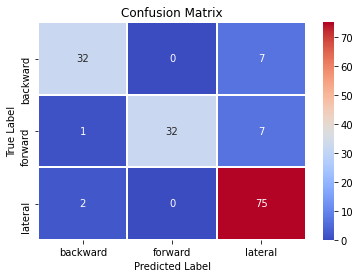


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.91      0.82      0.86        39
           1       1.00      0.80      0.89        40
           2       0.84      0.97      0.90        77

    accuracy                           0.89       156
   macro avg       0.92      0.86      0.89       156
weighted avg       0.90      0.89      0.89       156



In [32]:
y_pred_test = model_lstm.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [33]:
model_lstm.save('best_model_lstm_fall_types.h5')

### 1D CNN + LSTM Model

In [44]:
model_lsnet = Sequential()
model_lsnet.add(Conv1D(100, 3, activation='relu', input_shape=(TIME_PERIODS,no_of_features)))
model_lsnet.add(MaxPooling1D(3))
model_lsnet.add(LSTM(200, return_sequences=True))
model_lsnet.add(Conv1D(100, 3, activation='relu'))
model_lsnet.add(MaxPooling1D(3))
model_lsnet.add(Conv1D(80, 3, activation='relu'))
model_lsnet.add(GlobalAveragePooling1D())
model_lsnet.add(Dropout(0.4))
model_lsnet.add(Dense(100, activation='relu'))
model_lsnet.add(Dense(len(LABELS), activation='softmax'))
print(model_lsnet.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 58, 100)           1900      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 19, 100)          0         
 1D)                                                             
                                                                 
 lstm_4 (LSTM)               (None, 19, 200)           240800    
                                                                 
 conv1d_10 (Conv1D)          (None, 17, 100)           60100     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 5, 100)           0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 3, 80)            

In [45]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS, no_of_features)
x_train.shape

(416, 60, 6)

In [46]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
]

# opt = optimizers.RMSprop(learning_rate=0.001, momentum=0.9)

model_lsnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 50

history = model_lsnet.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/50
3/3 [==============================] - 2s 27ms/step - loss: 1.0650 - accuracy: 0.4303
Epoch 2/50
3/3 [==============================] - 0s 24ms/step - loss: 0.9486 - accuracy: 0.6779
Epoch 3/50
3/3 [==============================] - 0s 21ms/step - loss: 0.8479 - accuracy: 0.6803
Epoch 4/50
3/3 [==============================] - 0s 22ms/step - loss: 0.7483 - accuracy: 0.6875
Epoch 5/50
3/3 [==============================] - 0s 22ms/step - loss: 0.6723 - accuracy: 0.6971
Epoch 6/50
3/3 [==============================] - 0s 22ms/step - loss: 0.5868 - accuracy: 0.7236
Epoch 7/50
3/3 [==============================] - 0s 21ms/step - loss: 0.5442 - accuracy: 0.7885
Epoch 8/50
3/3 [==============================] - 0s 22ms/step - loss: 0.4302 - accuracy: 0.8101
Epoch 9/50
3/3 [==============================] - 0s 21ms/step - loss: 0.3768 - accuracy: 0.8582
Epoch 10/50
3/3 [==============================] - 0s 21ms/step - loss: 0.3174 - accuracy: 0.8726
Epoch 11/50
3/3 [============

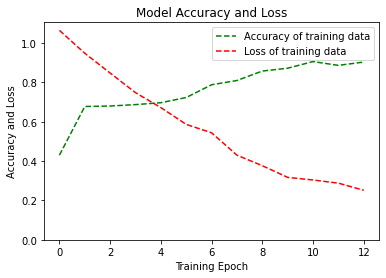

In [47]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [48]:
x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS, no_of_features)
x_test.shape

(156, 60, 6)

In [49]:
score = model_lsnet.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

5/5 [==============================] - 1s 27ms/step - loss: 0.2930 - accuracy: 0.8974

Accuracy on test data: 0.90

Loss on test data: 0.29


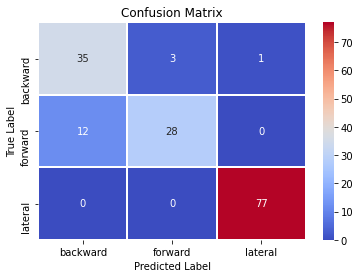


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.74      0.90      0.81        39
           1       0.90      0.70      0.79        40
           2       0.99      1.00      0.99        77

    accuracy                           0.90       156
   macro avg       0.88      0.87      0.87       156
weighted avg       0.91      0.90      0.90       156



In [50]:
y_pred_test = model_lsnet.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [51]:
model_lsnet.save('best_model_lsnet_fall_types.h5')